# FloydHub Introduction to Deep Learning: Convolutional Neural Networks

<p align="center">
  <img src="https://blog.floydhub.com/static/5dbb96f16b91ac0639a42e2dfbd0d901-47668.jpg"/>
</p>

## Introduction

Hello there! Welcome to part 3 in FloydHub's introduction to Deep Learning mini-series. Before we begin, let's summarize over what we've been through so far,

  1. Introduced PyTorch - a popular deep learning framework based in Python, with some basic lingo associated with deep learning workflow.
  2. Explored how Neural Networks structurally function & how the data flows through the layered architecture.
  3. Implemented our first deep learning pipeline with the MNIST task of classifying handwritten digits through two methods -- The simple yet powerful logistic regression & a single layer Neural Network.

From this point on, we are going to explore the different Neural Network architectures designed in specific domains. For example, in this & the next article we'll be exploring the ever powerful Convolutional Neural Networks and their ranging applications in Computer Vision. We'll start off by implementing one on the MNIST data itself but gradually proceed to a more intuitive dataset. Our goal would be to make you understand (& implement) how this process of Convolution works & why it's far more efficient than deep multi-layer perceptrons.

It is interesting to know that by introducing ConvNets, we're finally moving to the stage in Deep Learning where the **GPU compute** we had talked about for so long, begins to shine. You'll see for yourself in a while.

## Motivation

Before understanding ConvNets, it is imperative to see why'd they came to be. We'll illustrate this using the same MNIST task. Remember how we used to plug in the pixels of an image & our network magically predicted the digit? Well, if you'd go through the notebook and see a sample of images in the MNIST dataset, there is one particular pattern you might notice -- the digit that the image represents **usually lies in the middle of the image**!

<p align="center">
  <img src="https://cdn-images-1.medium.com/max/800/1*5ciREAL7xdyXcD-cSRP7Jw.png"/>
  </p>

So what happens when our test images do not follow this pattern? As you could probably guess...**it fails** to correctly classify the image. As another example, you could try feeding in a coloured image in our previous model, & it'll yet again fail because it has no idea what colours are or what their pixels represent. That doesn't seem very useful in the real world, now does it?

One particular solution to this problem is feeding in more data to the network; we apply a a ton of rotation, transposition, resizing operations on a single image to generate a higher number of samples of the same class & train a **deeper network**.

<p align="center">
<img src="https://cdn-images-1.medium.com/max/800/1*biD9eS5eB6zXzieonNk-VQ.png"/>
</p>

Now we have an endless supply of data & a very deep network to train with. So now, for every single image, we generate all its variants by altering color schemes, size ratios etc etc. Make much sense? Of course not!

And that's the motivation behind Convolutional Neural Networks! We wish to create a network architecture that is ***translationally invariant***.

## What's a ConvNet?

In layman terms, ConvNets look for symmetrical features in the input data. Each Convolutional layer has a set of **filters** that helps the network in this feature extraction. As the depth of such a network increases, complexity of the network increases as well. In our example, for instance, the first layer of convolution may capture simpler features such as the kind of channels (colors) while the last layer may capture complex features such as contours.

<p align="center">
<img src="http://machinelearninguru.com/_images/topics/computer_vision/basics/convolutional_layer_1/rgb.gif"/>
</p>

>Image: MLGuru

The illustration above portrays the operation of a convolutional layer. Imagine you have an RGB image, represented by `[number_of_channels (colors) x height x weight]`, in this case, `[3 x 5 x 5]` and we create `3` **filters** of `[3 x 3]` each. That is to say, `[3 x 3 x 3]` filters slide over the entire image and along the way take the dot products between filter values & chunks of the input image to get a `[1 x 4 x 4]` **feature map**. Since each convolutional layer consists of its own **filter**, if we stack `n` number of these with each independently convolved with the image, we end up with `n` feature maps! But **what's the point?** Because these filters are initialized randomly and thus, become our parameters which will be learned by the network subsequently.

Convolutional layers are often interweaved with **pooling layers**. Max Pooling, being a popular choice, takes the maximum of features over a small blocks of a previous layer. Thus, the output tells us **if a feature was present in the region, but not precisely where**.

<p align="center">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg"/>
</p>

How does pooling help? It allows the later convolutional layers to work on a larger subset of data, because a small patch of data *after pooling* represents a much bigger subsection before the pooling operation, making the network **invariant** to small transformations.

#### Striding & Padding

Striding & Padding are the two hyperparamters that can be used to alter the behaviour of each convolutional layer. **Stride** controls how the filter convolves of the image. The amount by which the filter shifts is the stride. In above illustration, the stride was implicitly set at 1. Stride is normally set in a way so that the output volume is an integer and not a fraction. Let’s look at an example.

<p align="center">
<img src="https://github.com/sominwadhwa/sominwadhwa.github.io/blob/master/assets/intro_to_pytorch_series/Stride1.png?raw=true"/>
</p>

A `[7 x 7]` input volume, with `[3 x 3]` filter with stride set to 1 gives a `[5 x 5]` feature map. Now let's try increasing the stride value to `2`,

<p align="center">
<img src="https://github.com/sominwadhwa/sominwadhwa.github.io/blob/master/assets/intro_to_pytorch_series/Stride2.png?raw=true"/>
</p>

The output volume shrinks! As you can see, we would normally increase the stride if we want less overlap & smaller spatial dimensions.

Now, let’s take a look at **padding**. Now imagine, what happens when you apply three 5 x 5 filters to a 32 x 32 x 3 input volume? The output volume would be a 28 x 28 x 3 feature map. Notice that the spatial dimensions decrease. As we make the network deeper, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features. Let’s say we want to apply the same convolutional layer but we want the output volume to remain 32 x 32 x 3. To achieve this, we could apply a zero padding of size 2 to that layer. Zero padding pads the input volume with zeros around the border. If we think about a zero padding of two, then this would result in a 36 x 36 x 3 input volume. If you have a stride of 1 and if you set the size of zero padding to `(K - 1)/2` where K is the filter size, then the input and output volume will always have the same spatial dimensions.

<p align="center">
<img src="https://github.com/sominwadhwa/sominwadhwa.github.io/blob/master/assets/intro_to_pytorch_series/Pad.png?raw=true"/>
</p>

>The formula for calculating the output size for any given convolutional layer is `(W - K + 2P)/S + 1` where O is the output ratio of height/length, W is the input ratio of height/length, K is the filter size, P is the padding, and S is the stride.

>Images: adeshpande3.github.io

### Hyperparameters

<p align="center">
<img src="https://media.mljar.com/blog/are-hyper-parameters-really-important-in-machine-learning/hyper-parameters.jpg"/>
</p>

Before moving on, let's take a minute to digest what we've learned so far and recapitulate. One particular aspect we'd like you think about here is about **Hyperparameters** -- things we encourage you to play next along this `jupyter notebook`.

  1. **ConvNet Layers:** How many? Filter Sizes? Stride/Padding? These may seem ordinary but they're not trivial matters. People often put in a lot of research into these factors since they determine the behaviour of convolutional operations.
  2. **ReLU Layers:** To introduce non-linearity (activation), it has been a convention to introduce one of these after every conv layer.  
  3. **Pooling Layers:** Max Pooling is surely the most popular choice here, but why? We leave this to you. Explore some other options & find out why!
  4. **1 x 1 convolution:** Often known as the `network-in-network` size filter. Performs N- Dimensional element-wise multiplications where N is the depth (color-channels) of the input volume into the layer.

There's sure more of these like Dropout, but more on that later.

## Let's build a ConvNet Model for training MNIST

You should now be familiar with the next steps: collect a dataset, build a model, train and evaluate.

### Collect a Dataset

For this task we will use the MNIST dataset that we have already uploaded for you as FloydHub dataset. If you have followed the steps in the README.md or in the article, you will be able to load the MNIST dataset from the input path.
First of all we import all the packages we need for running this tutorial:
- `torch`, our DL framework
- `torchvision`, package to handle pytorch Dataset for computer vision task
- `torch.nn`, package we need to create our Models
- `numpy` package to handle vector representation
- `matplotlib` to plot graphs

In [2]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

# Seed for replicability
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. torchvision.datasets provide a great API to handle the MNIST dataset. The snippet of code below, will create the MNIST dataset, then we will dive into to take a look about MNIST samples.

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


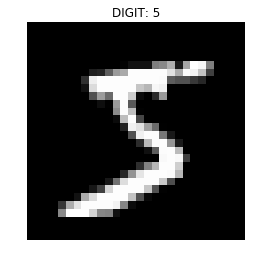

In [3]:
# MNIST Dataset (Images and Labels)
# If you have not mounted the dataset, you can download it
# just adding download=True as parameter
train_dataset = dsets.MNIST(root='/input', 
                            train=True, 
                            transform=transforms.ToTensor())
x_train_mnist, y_train_mnist = train_dataset.train_data.type(torch.FloatTensor), train_dataset.train_labels
test_dataset = dsets.MNIST(root='/input', 
                           train=False, 
                           transform=transforms.ToTensor())
x_test_mnist, y_test_mnist = test_dataset.test_data.type(torch.FloatTensor), test_dataset.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.axis('off')
plt.show()

torch.utils.data.DataLoader combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

In [4]:
# Hyperparameter
batch_size = 8

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

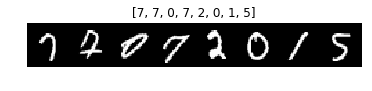

In [5]:
# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

In [6]:
# Hyperparameter
batch_size = 64

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Building a ConvNet in PyTorch

So let's get back to building a ConvNet in PyTorch on our initial task of classifying handwritten digits on the MNIST dataset. Since most of the data pre-processing parameters remain the same, all you have to do is stack up a few pre-programmed layers of convolutional instead of linear ones.

Before you get to that snippet, a few pointers for you to relate -

  1. Since the MNIST provides grayscale images, the number of channels = 1 (e.g for RGB, it is 3)
  2. `kernel_size` specifies the size of convolving filter for each convolutional layer.
  3. By default, there is no padding applied and the stride is set to 1.
  4. Network architecture that we wish to build is of the form -- `ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> Softmax`
  5. You'll see we've added a dropout layer here as well which, for the time being let's just say, is a form of regualizer. We'll get into the details of its working later.

This is what the model looks like:

![MNIST convnet model](https://raw.githubusercontent.com/floydhub/mnist/master/images/mnist_convet.png)

In [8]:
# Hyperparameters
input_size = 784 # 28 * 28
hidden_size = 500
num_classes = 10
learning_rate = 1e-3

#### Model ####
# Convolutional Neural Network Model
class CNN(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = CNN(num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()
    
#### Loss and Optimizer ####
# Softmax is internally computed.
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()
    
# Set parameters to be updated.  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train
We will train our model for 5 epochs and evaluate on test set.

In [9]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images)
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 0.8850, Accuracy: 76.5625
Epoch: [1/5], Step: [200/937], Loss: 0.6715, Accuracy: 75.0000
Epoch: [1/5], Step: [300/937], Loss: 0.3822, Accuracy: 89.0625
Epoch: [1/5], Step: [400/937], Loss: 0.3118, Accuracy: 90.6250
Epoch: [1/5], Step: [500/937], Loss: 0.2981, Accuracy: 90.6250
Epoch: [1/5], Step: [600/937], Loss: 0.3276, Accuracy: 92.1875
Epoch: [1/5], Step: [700/937], Loss: 0.3240, Accuracy: 90.6250
Epoch: [1/5], Step: [800/937], Loss: 0.2337, Accuracy: 89.0625
Epoch: [1/5], Step: [900/937], Loss: 0.1282, Accuracy: 95.3125
Epoch: [2/5], Step: [100/937], Loss: 0.3777, Accuracy: 87.5000
Epoch: [2/5], Step: [200/937], Loss: 0.3555, Accuracy: 90.6250
Epoch: [2/5], Step: [300/937], Loss: 0.1391, Accuracy: 98.4375
Epoch: [2/5], Step: [400/937], Loss: 0.2995, Accuracy: 89.0625
Epoch: [2/5], Step: [500/937], Loss: 0.1718, Accuracy: 95.3125
Epoch: [2/5], Step: [600/937], Loss: 0.1901, Accuracy: 93.7500
Epoch: [2/5], Step: [700/937], Loss: 0.2464, Accuracy: 

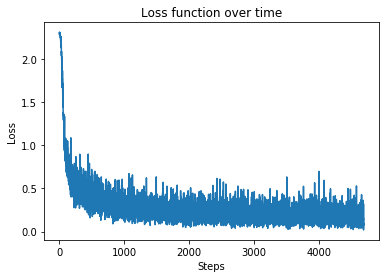

In [10]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

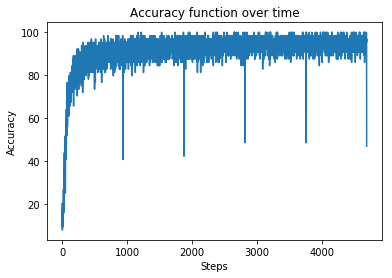

In [11]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

As you can see, the training procedure hasn't changed much. So what'd we gain?

### Evaluate
Let's evaluate our model on test set.

In [12]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 98.34%


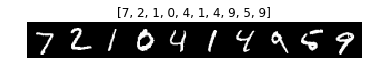

In [13]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

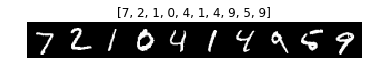

In [14]:
# Result from Training

input = Variable(images, volatile=True)
if cuda:
    input = input.cuda()
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

Our simple ConvNet makes the classifier so powerful that now there's a less than 2% chance of misclassification!

If you're into something more challenging that MNIST, you can refer to the article about [Building ConvNets](https://blog.floydhub.com/building-your-first-convnet/) from our blog & implement a ConvNet in PyTorch on a whole new dataset, DogsVsCats. This'll be fun since the images are in RGB format (3 channel input) & you'll really begin to see that GPU compute shine & slice through this task in minutes.

## Is that it?

So you take a dataset, build a ConvNet, make it deeper to learn more complex features & that's it? Well, there's more to this world of Computer Vision & ConvNet and since we're in the flow, it's only appropriate to mention [ImageNet Large Scale Visual Recognition Challenge](http://www.image-net.org/challenges/LSVRC/) or ILSVRC, as it is popularly known. ILSVRC is an annual competition where research teams evaluate their algorithms on the given data set, and compete to achieve higher accuracy on several visual recognition tasks, one most prominent being, a classification task with nearly 1000 classes. Think of it as the annual Olympics in Computer Vision. Until around 2011, a good ILSVRC classification error rate was 25%. In 2012, a deep convolutional neural net achieved 16%; in the next couple of years, error rates fell to a few percent. By 2015, researchers reported that software exceeded human ability at the narrow ILSVRC tasks. How'd they do that?

<p align="center">
<img src="https://github.com/sominwadhwa/sominwadhwa.github.io/blob/master/assets/intro_to_pytorch_series/img_net.jpg?raw=true"/>
</p>

Geoffrey Hinton, often known as the father of deep learning, along with Alex Krizhevsky and their SuperVision Group designed the one of the first deep convolutional neural network for this task, known as the AlexNet. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points ahead of the runner up.

<p align="center">
<img src="https://world4jason.gitbooks.io/research-log/content/deepLearning/CNN/Model%20&%20ImgNet/alexnet/img/alexnet2.png"/>
</p>

In fact, AlexNet has been so influential that its paper, titled “ImageNet Classification with Deep Convolutional Networks”, has been cited a total of 6,184 times and is widely regarded as one of the most influential publications in the field.

Soon after AlexNet, Oxford's Visual Geometry Group followed along with their own version of a successful Deep ConvNet, the [VGG-Net](https://arxiv.org/pdf/1409.1556v6.pdf) in 2014. VGG-Net was particularly interesting because it was one of the last "simple" deep convnet architecture to successfully crack the ILSVRC. After VGG-Net, Google came along with its [LeNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) & Inception modules and threw the idea of simplicity out the window! But more on that, later!

<p align="center">
<img src="https://adeshpande3.github.io/assets/GoogLeNet3.png"/>
</p>

Now you may ask, and rightly so, Google built a super complicated ConvNet on a specific kind of dataset. What do I do with that? And that brings us to our next article in this series where we take up **[Transfer Learning](http://ruder.io/transfer-learning/)**. Put simply, the transfer of knowledge from ILSVRC's winning ConvNet to your tiny ConvNet for classifying the images of Dogs & Cats.

## ConvNet Exercices Suggestion

As for the previuos article we encourage you to try different things:

- Weight Initializattion,
- Substitute ReLU with Sigmoid, Tanh and/or Swish,
- Add more layers, change Conv Filter, and/or the number of hidden units
- Add batch or layer normalization
- Try different Optimizer
- Try different combinations of the previuos suggestions

You have many knobs and components to try, it's your turn to get your hands dirty ;)

## Summary

That's all for this one. Again, now it's your turn to experiment. We know it's a lot to grasp & they key here is to not lose touch with the practical implementation of these concepts. So practice as much as you can, there's more coming. In the next article, we'll show you how to build a state-of-the-art classifier using Transfer Learning using one of ILSVRC's winning ConvNet.